# Classifying Segments Directly with a Neural Network

From here: https://dmbee.github.io/seglearn/auto_examples/plot_segment_rep.html

## Overview

This is a basic example using a convolutional recurrent neural network to learn segments directly from time series data.

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
from tensorflow.python.keras.layers import Dense, LSTM, Conv1D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier

In [3]:
from seglearn.datasets import load_watch
from seglearn.pipe import Pype
from seglearn.transform import Segment

In [4]:
# Define Conv/RNN model.
def crnn_model(
    width=100, 
    n_vars=6, 
    n_classes=7, 
    conv_kernel_size=5,
    conv_filters=3, 
    lstm_units=3
):
    input_shape = (width, n_vars)
    model = Sequential()
    model.add(
        Conv1D(
            filters=conv_filters, 
            kernel_size=conv_kernel_size,
            padding='valid', 
            activation='relu', 
            input_shape=input_shape
        )
    )
    model.add(
        Conv1D(
            filters=conv_filters, 
            kernel_size=conv_kernel_size,
            padding='valid', 
            activation='relu'
        )
    )
    model.add(
        LSTM(
            units=lstm_units, 
            dropout=0.1, 
            recurrent_dropout=0.1
        )
    )
    model.add(Dense(n_classes, activation="softmax"))

    model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

In [5]:
# load the data
data = load_watch()
X = data['X']
y = data['y']

In [6]:
print(type(X))
print(len(X))
print(X[0].shape)
print(X[2].shape)
print(X[3].shape)

<class 'list'>
140
(1333, 6)
(2197, 6)
(1597, 6)


In [7]:
print(type(y))
print(y.shape)
print(y[0:3])
print(np.unique(y))

<class 'numpy.ndarray'>
(140,)
[0 2 2]
[0 1 2 3 4 5 6]


In [8]:
# create a segment learning pipeline
pipe = Pype(
    [
        (
            'seg', 
            Segment(
                width=100, 
                step=100, 
                order='C'
                # ^ From: https://dmbee.github.io/seglearn/transform.html#seglearn.transform.Segment
                # Determines the index order of the segmented time series. 
                # ‘C’ means C-like index order (first index changes slowest) and ‘F’ means 
                # Fortran-like index order (last index changes slowest). 
                # ‘C’ ordering is suggested for neural network estimators, 
                # and ‘F’ ordering is suggested for computing feature representations.
            )
        ),
        (
            'crnn', 
            KerasClassifier(
                build_fn=crnn_model, 
                epochs=10, 
                batch_size=256, 
                verbose=0
            )
        )
    ]
)

/mnt/space/miniconda3/envs/py38_playaround-sk/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass memory=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [9]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [10]:
pipe.fit(X_train, y_train)

/mnt/space/miniconda3/envs/py38_playaround-sk/lib/python3.8/site-packages/seglearn/transform.py:237: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Xt = np.array([sliding_tensor(Xt[i], self.width, self._step, self.order)


Pype(steps=[('seg', Segment(order='C', overlap=None, step=100)),
            ('crnn',
             <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f1373e0a5e0>)])

In [11]:
score = pipe.score(X_test, y_test)
score

0.11092150211334229

N series in train:  105
N series in test:  35
N segments in train:  1783
N segments in test:  586
Accuracy score:  0.11092150211334229


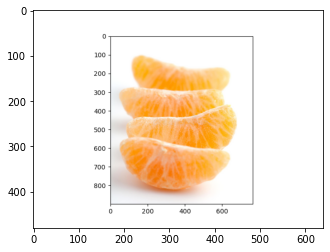

In [12]:
print("N series in train: ", len(X_train))
print("N series in test: ", len(X_test))
print("N segments in train: ", pipe.N_train)
print("N segments in test: ", pipe.N_test)
print("Accuracy score: ", score)

img = mpimg.imread('https://dmbee.github.io/seglearn/_images/sphx_glr_plot_segment_rep_001.png')
plt.imshow(img)